## Imports

In [67]:
import os
supp_path = 'C:/Users/joepo/Desktop/Back Testing/Supplemental'
import sys
sys.path.insert(1, supp_path)
import rando 
import strats
import myIndicators as mind
import model_analysis as ma

import backtrader as bt
import datetime
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

## Variables

In [35]:
allTickers = ['ABT', 'ATVI', 'CSCO', 'CVS', 'LOW', 'NKE', 'SBUX', 'T'
              , 'BAC', 'DAL', 'GE', 'SIRI', 'WFC'
              , 'GOOG', 'GME', 'LB', 'LUV', 'AAL','HD', 'UAA'
              , 'WMT', 'JPM', 'BCS', 'YUM', 'BA', 'BAC', 'AAPL', 'C'
              , 'DIS', 'GILD', 'H', 'K', 'KO', 'M'
              , 'MSFT', 'NVDA', 'NFLX', 'PENN', 'QCOM', 'RCL'
              , 'USO', 'V', 'VZ'
              , 'WFC', 'COST', 'X', 'XOM']
startDate = '2010-1-1'
endDate = '2020-5-15'
datedict = {'d':'%Y-%m-%d'}
iterator = 'd'
outPath = 'C:/Users/joepo/Desktop/Back Testing/Data/Testing'

In [36]:
startingcash = 200000
sizingperc = 0.05
fast_sma = 20
slow_sma = 100
boll_std = 1
range_dist_min = 1.7
range_dist_max = 2.3
exit_dist = 3.15
reset_dist = 1.15
rsi_thresh = 20
rsi_close = 10
rsi_period = 14
profit = 0.075

## Download Data

In [37]:
#get dates for data
today = date.today()
#endDate = datetime.datetime.strftime(today, datedict[iterator])
start = today - datetime.timedelta(days = 350)

#iterate through tickers and download data
print('Downloading data ... ')
for t in allTickers:
    print(t)
    data = pdr.get_data_yahoo(t.strip().upper(), start=startDate, end=endDate)
    data.to_csv(os.path.join(outPath, t+'.csv'))

ABT
[*********************100%***********************]  1 of 1 completed
ATVI
[*********************100%***********************]  1 of 1 completed
CSCO
[*********************100%***********************]  1 of 1 completed
CVS
[*********************100%***********************]  1 of 1 completed
LOW
[*********************100%***********************]  1 of 1 completed
NKE
[*********************100%***********************]  1 of 1 completed
SBUX
[*********************100%***********************]  1 of 1 completed
T
[*********************100%***********************]  1 of 1 completed
BAC
[*********************100%***********************]  1 of 1 completed
DAL
[*********************100%***********************]  1 of 1 completed
GE
[*********************100%***********************]  1 of 1 completed
SIRI
[*********************100%***********************]  1 of 1 completed
WFC
[*********************100%***********************]  1 of 1 completed
GOOG
[*********************100%*******************

# Get Data (Random Timeframes)

In [38]:
data_grab_dict = {}
for t in allTickers:
    ticker, startdate, enddate, dateformat, numdays = rando.main(outPath, datedict, iterator, t)
    #print("Running backtest from {} to {} on {}; ({} days)".format(startdate, enddate, ticker, numdays))
    data_grab_dict[t] = [startdate, enddate]

## Strategy

In [39]:
class live_model_1(bt.Strategy):
    '''
    SMA mean reverting
    '''
    params = dict(
        sizingPerc = 0.01
        ,fastSMA = 20
        ,slowSMA = 100
        ,bollStd = 1
        ,rangeLow = 1.75
        ,rangeHigh = 2.25
        ,stopRange = 2.5
        ,resetRange = 1.5
        ,rsiBound = 20
        ,rsiClose = 5
        ,rsiPeriod = 14
        ,profitTake = 0.1
        ,printLog = True
        )

    def __init__(self):
        self.startCash = None
        self.order = {}
        self.stoploss = {}
        self.fastSlow = {}
        self.smaCrosses = {}
        self.distInRange = {}
        self.revertEarly = {}
        self.rsiCross = {}
        self.ls = {}
        self.highStop = {}
        self.lowStop = {}
        self.tradedata = {}
        self.reldata = {}
        self.price = {}
        self.inds = {}
        for i, d in enumerate(self.datas):
            self.order[d] = None
            self.stoploss[d] = None
            self.fastSlow[d] = None
            self.smaCrosses[d] = 0
            self.distInRange[d] = False
            self.revertEarly[d] = False
            self.rsiCross[d] = None
            self.ls[d] = 0
            self.highStop[d] = 0
            self.lowStop[d] = 0
            self.reldata[d] = []
            self.price[d] = 0
            self.inds[d] = {}
            self.inds[d]['sma fast'] = bt.ind.SMA(d.close, period = self.p.fastSMA).lines.sma
            self.inds[d]['sma slow'] = bt.ind.SMA(d.close, period = self.p.slowSMA).lines.sma
            self.inds[d]['bands'] = bt.ind.BBands(d.close, period = self.p.fastSMA, devfactor = self.p.bollStd, plot=False)
            self.inds[d]['band diff'] = self.inds[d]['bands'].lines.top - self.inds[d]['bands'].lines.mid
            self.inds[d]['rsi'] = bt.ind.RSI_SMA(d.close, period = self.p.rsiPeriod).lines.rsi
            self.inds[d]['rsi buy'] = bt.ind.CrossDown(self.inds[d]['rsi'], 50 - self.p.rsiBound, plot=False)
            self.inds[d]['rsi sell'] = bt.ind.CrossUp(self.inds[d]['rsi'], 50 + self.p.rsiBound, plot=False)
            self.inds[d]['rsi close long'] = bt.ind.CrossUp(self.inds[d]['rsi'], 50 + self.p.rsiClose, plot=False)
            self.inds[d]['rsi close short'] = bt.ind.CrossDown(self.inds[d]['rsi'], 50 - self.p.rsiClose, plot=False)

    def start(self):
        self.startCash = self.broker.getvalue()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            d = order.data
            if order.isbuy():
                bs = "Bought"
                self.ls[d] = 1
            else:
                bs = "Sold"
                self.ls[d] = -1
            desc = "{} {} shares of {} for ${:.2f}".format(bs, order.executed.size, d._name, order.executed.price)
            self.log(desc)
            self.price[d] = order.executed.price
            if len(self.reldata[d]) == 12:
                self.reldata[d].append('Stop')
            self.reldata[d].append(desc)
        elif order.status in [order.Canceled]:
            self.log('Order Canceled for {}'.format(order.data._name))
        elif order.status in [order.Margin, order.Rejected]:
            self.log('Order rejected or margin issue')

    def notify_trade(self, trade):
        d = trade.data
        if not trade.isclosed:
            return
        self.reldata[d].append(trade.pnlcomm)
        self.tradedata[self.reldata[d][11]] = self.reldata[d]
        self.cancel(self.stoploss[d])
        self.stoploss[d] = None
        self.resetBools(d)

    def resetBools(self, t):
        self.fastSlow[t] = None
        self.smaCrosses[t] = 0
        self.distInRange[t] = False
        self.revertEarly[t] = False
        self.rsiCross[t] = None
        self.ls[t] = 0
        self.reldata[t] = []
        self.price[t] = 0

    def log(self, txt, dp=False):
        if self.p.printLog or dp:
            date = self.datas[0].datetime.date(0)
            print("{}: {}".format(date, txt))

    def sizingCalc(self, capital, price):
        available = float(capital) * self.p.sizingPerc
        shares = round(available/price)
        return shares

    def awayThreshold(self, thresh, fast, close, ab):
        if ab == "Above":
            new = float(fast) * (1 + float(thresh))
            if float(close) > new:
                return True
            else:
                return False
        elif ab == "Below":
            new = float(fast) * (1 - float(thresh))
            if float(close) < new:
                return True
            else:
                return False
        else:
            self.log("awayThreshold:  We have a problem: {}".format(ab))

    def resetAway(self, reset, fast, close, ab):
        if ab == "Above":
            new = float(fast) * (1 + float(reset))
            if float(close) > new:
                return True
            else:
                return False
        elif ab == "Below":
            new = float(fast) * (1 - float(reset))
            if float(close) < new:
                return True
            else:
                return False

    def next(self):
        for i, d in enumerate(self.datas):
            fast = self.inds[d]['sma fast'][0]
            slow = self.inds[d]['sma slow'][0]
            bollWidth = self.inds[d]['band diff'][0]
            rsi = self.inds[d]['rsi'][0]
            close = d.close[0]
            ticker = d._name
            if self.getposition(d).size == 0: ##not in market
                if fast > slow: ##fast above slow ma
                    self.fastSlow[d] = "Above"
                    if self.distInRange[d]:
                        if close < fast + (bollWidth * self.p.resetRange):
                            ##fell out of range
                            self.distInRange[d] = False
                        else:
                            ##still in range
                            if self.inds[d]['rsi sell'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.sell(data=d, size=numShares)
                                self.log("Sell {} shares of {}".format(numShares, ticker))
                                self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append(rsi - (50 + self.p.rsiBound))
                    else:
                        lowRange = bollWidth * self.p.rangeLow
                        highRange = bollWidth * self.p.rangeHigh
                        if close > (fast + lowRange) and close < (fast + highRange):
                            self.distInRange[d] = True
                            if self.inds[d]['rsi sell'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.sell(data=d, size=numShares)
                                self.log("Sell {} shares of {}".format(numShares, ticker))
                                self.highStop[d] = fast + (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append(rsi - (50 + self.p.rsiBound))

                elif fast < slow: ##fast below slow sma
                    self.fastSlow[d] = "Below"
                    if self.distInRange[d]:
                        if close > fast - (bollWidth * self.p.resetRange):
                            ##fell out of range
                            self.distInRange[d] = False
                        else:
                            ##still in range
                            if self.inds[d]['rsi buy'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.buy(data=d, size = numShares)
                                self.log("Buy {} shares of {}".format(numShares, ticker))
                                self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append((50 - self.p.rsiBound) - rsi)
                    else:
                        lowRange = bollWidth * self.p.rangeLow
                        highRange = bollWidth * self.p.rangeHigh
                        if close > (fast - highRange) and close < (fast - lowRange):
                            self.distInRange[d] = True
                            if self.inds[d]['rsi buy'].lines.cross[0] > 0:
                                numShares = self.sizingCalc(self.broker.getvalue(), close)
                                self.order[d] = self.buy(data=d, size = numShares)
                                self.log("Buy {} shares of {}".format(numShares, ticker))
                                self.lowStop[d] = fast - (bollWidth * self.p.stopRange)
                                self.reldata[d].extend([ticker, fast, slow, abs(fast-slow), bollWidth, rsi])
                                self.reldata[d].extend([fast/close, slow/close, abs(fast-slow)/close, bollWidth/close])
                                self.reldata[d].append((50 - self.p.rsiBound) - rsi)

            else:
                if self.ls[d] < 0: ##sold
                    if self.stoploss[d] is None:
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price=self.highStop[d]
                                                      )
                        self.log("Buy stop created at ${:.2f} for {}".format(
                            self.highStop[d], ticker))
                    ##check for rsi cross
                    if close < self.price[d] * (1-self.p.profitTake):
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("Take {}% profit and close {}".format(self.p.profitTake*100.0, ticker))
                        self.reldata[d].append('Profit')
                    elif self.inds[d]['rsi close short'].lines.cross[0] > 0:
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("RSI broke below for {}, close position".format(ticker))
                        self.reldata[d].append('RSI')
                    ##check for number of sma crosses #starts above
                    elif self.smaCrosses[d] == 0:
                        ##check for sma cross below
                        if fast < slow:
                            self.smaCrosses[d] = 1
                    elif self.smaCrosses[d] == 1:
                        if fast > slow:
                            ##sma crossed back above, exit short position
                            self.order[d] = self.close(data=d)
                            self.cancel(self.stoploss[d])
                            self.log("Upward momentum with SMA crossing up for {}, close position".format(ticker))
                            self.reldata[d].append('SMA Cross')
                else:  ##bought
                    if self.stoploss[d] is None:
                        self.stoploss[d] = self.close(data=d
                                                      ,exectype=bt.Order.Stop
                                                      ,price=self.lowStop[d]
                                                      )
                        self.log("Sell stop created at ${:.2f} for {}".format(
                            self.lowStop[d], ticker))
                    if close > self.price[d] * (1+self.p.profitTake):
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("Take {}% profit and close {}".format(self.p.profitTake*100.0, ticker))
                        self.reldata[d].append('Profit')
                    ##check for rsi cross
                    elif self.inds[d]['rsi close long'].lines.cross[0] > 0:
                        self.order[d] = self.close(data=d)
                        self.cancel(self.stoploss[d])
                        self.log("RSI broke above for {}, close position".format(ticker))
                        self.reldata[d].append('RSI')
                    elif self.smaCrosses[d] == 0:
                        ##check for sma cross above
                        if fast > slow:
                            self.smaCrosses[d] = 1
                    elif self.smaCrosses[d] == 1:
                        if fast < slow:
                            ##sma crossed back below, exit long position
                            self.order[d] = self.close(data=d)
                            self.cancel(self.stoploss[d])
                            self.log("Downard momentum with SMA crossing down for {}, close position".format(ticker))
                            self.reldata[d].append('SMA Cross')
                        
    def stop(self):
        pnl = self.broker.getvalue() - self.startCash
        print("\n\n ------- Final Analysis ------- ")
        print("Ending Value: ${:.2f}\nP&L:  ${:.2f}\n".format(self.broker.getvalue(), pnl))

In [40]:
class custom_analyzer(bt.Analyzer):
    def get_analysis(self):
        return self.strategy.tradedata

In [41]:
class custom_analyzer2(bt.Analyzer):
    def get_analysis(self):
        return self.strategy.broker.getvalue() - self.strategy.startCash

## Run Strategy

In [42]:
allData = []
pnls = []
for key, value in data_grab_dict.items():
    print(key)
    cerebro = bt.Cerebro()
    data = bt.feeds.GenericCSVData(dataname = os.path.join(outPath, key + '.csv')
                                   ,fromdate = value[0]
                                   ,todate = value[1]
                                   ,nullvalue = 0.0
                                   ,dtformat = datedict[iterator]
                                   ,datetime = 0
                                   ,high = 2
                                   ,low = 3
                                   ,open = 1
                                   ,close = 4
                                   ,volume = 6
                                   ,openinterest = -1 #no open interest column
                                   )
    cerebro.adddata(data, name=key)
    
    cerebro.broker.set_cash(startingcash)
    print("Running with ${} as starting cash".format(startingcash))
    print("Trading {:.2f}% of portfolio value".format(sizingperc * 100.0))
    cerebro.addstrategy(live_model_1
                    ,sizingPerc = sizingperc
                    ,fastSMA = fast_sma
                    ,slowSMA = slow_sma
                    ,bollStd = boll_std
                    ,rangeLow = range_dist_min
                    ,rangeHigh = range_dist_max
                    ,stopRange = exit_dist
                    ,resetRange = reset_dist
                    ,rsiBound = rsi_thresh
                    ,rsiClose = rsi_close
                    ,rsiPeriod = rsi_period
                    ,profitTake = profit
                    ,printLog = False
                    )
    
    #add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='annRets')
    cerebro.addanalyzer(custom_analyzer, _name='tradeDict')
    cerebro.addanalyzer(custom_analyzer2, _name='pnl')
    
    #run backtest
    test = cerebro.run()
    analysis = test[0]
    
    #get analyzers
    sharpe = analysis.analyzers.sharpe.get_analysis()
    sqn = analysis.analyzers.sqn.get_analysis()
    rets = analysis.analyzers.annRets.get_analysis()
    trade = analysis.analyzers.trades.get_analysis()
    trades = analysis.analyzers.tradeDict.get_analysis()
    pl = analysis.analyzers.pnl.get_analysis()
    
    #print analysis
    print(ma.main_analysis(sharpe, sqn, rets))
    
    allData.append(trades)
    pnls.append(pl)

ABT
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $199687.46
P&L:  $-312.54

 ------ Quick Glance ------ 
Sharpe Ratio:  -24.15
SQN:  -0.3746899543394708
5 total trades
Normalized Return:  -0.10%
Total Return:  -0.00
Average Return:  -0.00
 -------------------------- 

ATVI
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $199525.35
P&L:  $-474.65

 ------ Quick Glance ------ 
Sharpe Ratio:  -3.00
SQN:  -0.22030036668574207
8 total trades
Normalized Return:  -0.08%
Total Return:  -0.00
Average Return:  -0.00
 -------------------------- 

CSCO
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $198380.18
P&L:  $-1619.82

 ------ Quick Glance ------ 
Sharpe Ratio:  -4.42
SQN:  -1.4869627057594414
12 total trades
Normalized Return:  -0.21%
Total Return:  -0.01
Average Return:  -



 ------- Final Analysis ------- 
Ending Value: $200310.65
P&L:  $310.65

 ------ Quick Glance ------ 
Sharpe Ratio:  -2.33
SQN:  0.24879567221149085
13 total trades
Normalized Return:  0.04%
Total Return:  0.00
Average Return:  0.00
 -------------------------- 

AAPL
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200593.91
P&L:  $593.91

 ------ Quick Glance ------ 
Sharpe Ratio:  -6.09
SQN:  0.5470396987597215
5 total trades
Normalized Return:  0.19%
Total Return:  0.00
Average Return:  0.00
 -------------------------- 

C
Running with $200000 as starting cash
Trading 5.00% of portfolio value


 ------- Final Analysis ------- 
Ending Value: $200029.24
P&L:  $29.24

 ------ Quick Glance ------ 
Sharpe Ratio:  -45.45
SQN:  0.017795096073800826
10 total trades
Normalized Return:  0.00%
Total Return:  0.00
Average Return:  0.00
 -------------------------- 

DIS
Running with $200000 as starting cash
Trading 5.00% o

In [43]:
sum(pnls)

-10306.013401055417

In [44]:
dfs = []
cols = ['Ticker', 'Fast SMA', 'Slow SMA', 'SMA Diff', 'Bollinger Width', 'RSI'
       , 'Fast Norm', 'Slow Norm', 'Diff Norm', 'Boll Norm', 'RSI Extra', 'Entry Desc'
       , 'Reason', 'Exit Desc', 'PnL']
for d in allData:
    df = pd.DataFrame.from_dict(d, orient='index', columns=cols).reset_index()
    dfs.append(df)
    
tradeData = pd.concat(dfs).reset_index(drop=True)
tradeData.rename({'index':'Description'}, axis=1, inplace=True)
tradeData['WL'] = tradeData['PnL'].apply(lambda x: 'W' if x > 0 else 'L')
tradeData['LS'] = tradeData['Description'].apply(lambda x: 'Long' if x.split(' ')[0] == 'Bought' else 'Short')
tradeData

Description Ticker   Fast SMA  Slow SMA  \
0     Sold -157 shares of ABT for $63.89    ABT  60.055000   57.6659   
1     Sold -149 shares of ABT for $66.94    ABT  65.023000   62.2274   
2     Sold -146 shares of ABT for $68.51    ABT  66.213000   62.9896   
3     Sold -138 shares of ABT for $72.00    ABT  69.022499   66.4435   
4     Sold -133 shares of ABT for $75.04    ABT  71.758500   70.4930   
..                                   ...    ...        ...       ...   
403   Sold -120 shares of XOM for $83.00    XOM  82.517500   80.4273   
404   Sold -119 shares of XOM for $83.98    XOM  83.088001   81.1236   
405   Sold -118 shares of XOM for $84.86    XOM  81.471500   81.0135   
406  Bought 132 shares of XOM for $76.24    XOM  79.325500   81.4710   
407  Bought 135 shares of XOM for $74.14    XOM  76.992500   77.3149   

     SMA Diff  Bollinger Width        RSI  Fast Norm  Slow Norm  Diff Norm  \
0    2.389100         1.626928  77.173942   0.943964   0.906412   0.037553   
1    2.795600         1.062384  72.677617   0.968613   0.926969   0.041645   
2    3.223400         1.029262  72.588861   0.966613   0.919556   0.047057   
3    2.578999         1.478280  71.626983   0.952034   0.916462   0.035572   
4    1.265500         1.550626  71.298575   0.956015   0.939155   0.016860   
..        ...              ...        ...        ...        ...        ...   
403  2.090200         0.587885  77.672987   0.988589   0.963547   0.025041   
404  1.964401         0.533803  70.558438   0.990322   0.966908   0.023414   
405  0.458000         1.508287  71.396109   0.962679   0.957267   0.005412   
406  2.145500         2.029038  27.059653   1.050808   1.079229   0.028421   
407  0.322400         1.649917  19.023539   1.043400   1.047769   0.004369   

     Boll Norm  RSI Extra                           Entry Desc Reason  \
0     0.025573   7.173942   Sold -157 shares of ABT for $63.89    RSI   
1     0.015826   2.677617   Sold -149 shares of ABT for $66.94   Stop   
2     0.015026   2.588861   Sold -146 shares of ABT for $68.51   Stop   
3     0.020390   1.626983   Sold -138 shares of ABT for $72.00   Stop   
4     0.020658   1.298575   Sold -133 shares of ABT for $75.04   Stop   
..         ...        ...                                  ...    ...   
403   0.007043   7.672987   Sold -120 shares of XOM for $83.00    RSI   
404   0.006362   0.558438   Sold -119 shares of XOM for $83.98   Stop   
405   0.017822   1.396109   Sold -118 shares of XOM for $84.86   Stop   
406   0.026878   2.940347  Bought 132 shares of XOM for $76.24   Stop   
407   0.022360  10.976461  Bought 135 shares of XOM for $74.14   Stop   

                               Exit Desc         PnL WL     LS  
0    Bought 157 shares of ABT for $59.57  678.239952  W  Short  
1    Bought 149 shares of ABT for $68.37 -212.996425  L  Short  
2    Bought 146 shares of ABT for $70.79 -332.879822  L  Short  
3    Bought 138 shares of ABT for $73.68 -231.713047  L  Short  
4    Bought 133 shares of ABT for $76.64 -213.195130  L  Short  
..                                   ...         ... ..    ...  
403  Bought 120 shares of XOM for $80.44  307.199707  W  Short  
404  Bought 119 shares of XOM for $84.77  -93.947926  L  Short  
405  Bought 118 shares of XOM for $86.22 -160.787313  L  Short  
406   Sold -132 shares of XOM for $72.93 -436.387556  L   Long  
407   Sold -135 shares of XOM for $71.80 -316.539876  L   Long  

[408 rows x 18 columns]

## Trade Analysis

#### Wins and Losses Breakdown

In [45]:
tradeData['WL'].value_counts(normalize=True)

L    0.659314
W    0.340686
Name: WL, dtype: float64

In [46]:
tradeData.groupby(['WL'])['PnL'].mean()

WL
L   -313.555717
W    528.851485
Name: PnL, dtype: float64

****Key Takeaways:****
Does a good job of limiting losses and letting winners work, just need to weed out the losses and keep the winners

#### Reason Breakdown

In [47]:
tradeData.groupby(['Reason', 'WL'])['Ticker'].count().unstack()

WL          L     W
Reason             
Profit    NaN  41.0
RSI       2.0  93.0
Stop    267.0   5.0

****Look for differences in entering metrics for stop vs the other****

****Decision Tree to predict Stop?****

****Sizing based on probability of profit?****

In [48]:
ls = tradeData.groupby(['LS', 'WL'])['Ticker'].count().unstack()
ls['Total'] = ls['L'] + ls['W']
ls['P(W)'] = ls['W'] / ls['Total']
ls

WL       L   W  Total      P(W)
LS                             
Long    66  54    120  0.450000
Short  203  85    288  0.295139

In [49]:
tradeData.groupby(['LS', 'Reason'])['Ticker'].count().unstack()

Reason  Profit  RSI  Stop
LS                       
Long        24   28    68
Short       17   67   204

#### Win/Loss Entry Metric Differences

In [50]:
def grouping(df, group, metric):
    a = df.groupby([group])[metric].mean()
    b = df.groupby([group])[metric].std()
    print('Mean:\n{}\n\nSigma:\n{}'.format(a, b))

In [51]:
grouping(tradeData, 'WL','Diff Norm')

Mean:
WL
L    0.054711
W    0.061687
Name: Diff Norm, dtype: float64

Sigma:
WL
L    0.056769
W    0.055253
Name: Diff Norm, dtype: float64


****Takeaway:**** Larger difference between fast and slow SMA is better. 

In [52]:
grouping(tradeData, 'WL', 'Boll Norm')

Mean:
WL
L    0.024790
W    0.029673
Name: Boll Norm, dtype: float64

Sigma:
WL
L    0.013672
W    0.020823
Name: Boll Norm, dtype: float64


****Takeaway:**** Wider bollinger bands is better.  Find this interesting

In [53]:
grouping(tradeData, 'WL', 'RSI Extra')

Mean:
WL
L    3.906083
W    4.301986
Name: RSI Extra, dtype: float64

Sigma:
WL
L    3.661095
W    3.757827
Name: RSI Extra, dtype: float64


****Takeaway:**** Not much difference between RSI level

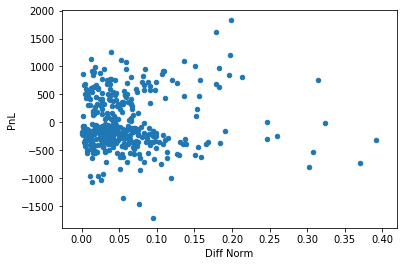

In [60]:
tradeData.plot.scatter(x='Diff Norm', y='PnL')

Slope: 451.87
Intercept: -52.36
R-Squared: 0.05


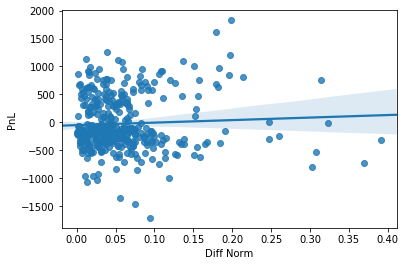

In [73]:
x = tradeData['Diff Norm']
y = tradeData['PnL']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print('Slope: {:.2f}'.format(slope))
print('Intercept: {:.2f}'.format(intercept))
print('R-Squared: {:.2f}'.format(r_value))

sns.regplot(x, y)

Slope: 1488.89
Intercept: -65.95
R-Squared: 0.05


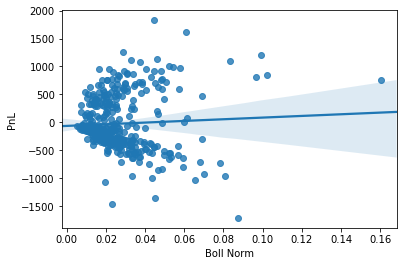

In [74]:
x = tradeData['Boll Norm']
y = tradeData['PnL']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print('Slope: {:.2f}'.format(slope))
print('Intercept: {:.2f}'.format(intercept))
print('R-Squared: {:.2f}'.format(r_value))

sns.regplot(x, y)

In [75]:
x = tradeData['RSI Extra']
y = tradeData['PnL']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print('Slope: {:.2f}'.format(slope))
print('Intercept: {:.2f}'.format(intercept))
print('R-Squared: {:.2f}'.format(r_value))

sns.regplot(x, y)

Slope: 0.49
Intercept: -28.54
R-Squared: 0.00


***
## W/L Prediction Model

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier as frst
from sklearn.tree import DecisionTreeClassifier as tr
from sklearn.linear_model import LogisticRegression as LogReg
import statsmodels.api as sm

from scipy import stats

In [86]:
forModel = tradeData[['Description', 'Ticker', 'Diff Norm', 'Boll Norm', 'RSI Extra', 'WL']]
forModel['WL2'] = forModel['WL'].apply(lambda x: 1 if x=='W' else 0)
forModel.drop(columns = ['WL'], inplace=True)
forModel.rename(columns = {'WL2':'WL'}, inplace=True)

forModel.drop(columns = ['Diff Norm'], inplace=True)
x = forModel.iloc[:,2:-1]
y = forModel.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(*

## Logistic Regression

In [87]:
lm = sm.OLS(y_train, sm.add_constant(x_train)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                     WL   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.350
Date:                Mon, 01 Jun 2020   Prob (F-statistic):             0.0365
Time:                        16:03:38   Log-Likelihood:                -180.18
No. Observations:                 273   AIC:                             366.4
Df Residuals:                     270   BIC:                             377.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2073      0.059      3.520      0.0

C:\Users\joepo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [ ]:
def pred(mod, x, y, pred_name, check_name, train_test='Train'):
    predictions = mod.predict(x)
    predictionsDF = pd.DataFrame(predictions, columns=[pred_name])
    checkDf = pd.concat((y, predictionsDF), axis=1)
    checkDF['Accurate'] = checkDF.apply(lambda x: 1 if x[check_name]==x[pred_name] else 0, axis=1)
    right = checkDF['Accurate'].sum()
    total = checkDF.shape[0]
    accuracy = right/total
    print('{} Set Accuracy:  {:.2f}%'.format(train_test, accuracy * 100.0))

In [88]:
#predictions

model = LogReg()
model.fit(x_train, y_train)

#training accuracy
train_pred = model.predict(x_train)
predictions = pd.DataFrame(train_pred, columns = ['WL Predict'])
train_predictions = pd.concat((y_train, predictions), axis=1)
train_predictions['Accurate'] = train_predictions.apply(lambda x: 1 if x['WL'] == x['WL Predict'] else 0, axis=1)
right = train_predictions['Accurate'].sum()
total = train_predictions.shape[0]
accuracy = right/total
print('Train Set Accuracy: {}'.format(accuracy))

#testing accuracy
test_pred = model.predict(x_test)
predictions = pd.DataFrame(test_pred, columns=['WL Predict'])
test_predictions = pd.concat((y_test, predictions), axis=1)
test_predictions['Accurate'] = test_predictions.apply(lambda x: 1 if x['WL']==x['WL Predict'] else 0, axis=1)
right = test_predictions['Accurate'].sum()
total = test_predictions.shape[0]
accuracy = right/total
print('Test Set Accuracy: {}'.format(accuracy))

Train Set Accuracy: 0.6556776556776557
Test Set Accuracy: 0.6666666666666666


C:\Users\joepo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [89]:
#confusion matrix
cm = train_predictions.groupby(['WL Predict', 'WL'])['Accurate'].count().unstack()
print(cm)

WL            0   1
WL Predict         
0           178  92
1             2   1


This model sucks

***
## Random Forest

In [90]:
forModel = tradeData[['Description', 'Ticker', 'Diff Norm', 'Boll Norm', 'RSI Extra', 'WL']]
forModel['WL2'] = forModel['WL'].apply(lambda x: 1 if x=='W' else 0)
forModel.drop(columns = ['WL'], inplace=True)
forModel.rename(columns = {'WL2':'WL'}, inplace=True)

x = forModel.iloc[:,2:-1]
y = forModel.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(*

In [91]:
forest = frst(random_state=1, max_depth = 4
                             ,min_samples_split = 10
                             ,min_samples_leaf = 4)
forest.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(forest.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


     variable  importance
1  Boll Norm    0.365209
0  Diff Norm    0.352868
2  RSI Extra    0.281923 



C:\Users\joepo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [92]:
#train predictions
train_pred = forest.predict(x_train)
predictions = pd.DataFrame(train_pred, columns=['WL Predict'])
train_predictions = pd.concat((y_train, predictions), axis=1)
train_predictions['Accurate'] = train_predictions.apply(lambda x: 1 if x['WL Predict']==x['WL'] else 0, axis=1)
right = train_predictions['Accurate'].sum()
total = train_predictions.shape[0]
accuracy = right / total
print('Train Set Accuracy:  {:.3f}%'.format(accuracy * 100.0))

#test predictions
test_pred = forest.predict(x_test)
predictions = pd.DataFrame(test_pred, columns=['WL Predict'])
test_predictions = pd.concat((y_test, predictions), axis=1)
test_predictions['Accurate'] = test_predictions.apply(lambda x: 1 if x['WL Predict']==x['WL'] else 0, axis=1)
right = test_predictions['Accurate'].sum()
total = test_predictions.shape[0]
accuracy = right / total
print('Test Set Accuracy:  {:.3f}%'.format(accuracy * 100.0))


Train Set Accuracy:  72.527%
Test Set Accuracy:  65.185%


In [93]:
#confusion matrix
cm = train_predictions.groupby(['WL Predict', 'WL'])['Accurate'].count().unstack()
print(cm)

WL            0   1
WL Predict         
0           177  72
1             3  21


In [94]:
true_pos = cm.iloc[1, 1] #predict W and W
true_neg = cm.iloc[0, 0] #predict L and L
false_pos = cm.iloc[1, 0] #predict W and L
false_neg = cm.iloc[0, 1] #predict L and W

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
recall = true_pos / (true_pos + false_neg) #P(W|W)
precision = true_pos / (true_pos + false_pos)  #P(W|predict W)

F_score = (2*recall*precision) / (recall + precision)

FPR = false_pos / (true_neg + false_pos) #P(wrong|L)
FNR = false_neg / (false_neg + true_pos)

loss_right = true_neg / (true_neg + false_neg)

print('Train Set:')
print('F-Score: {:.3f}'.format(F_score))
print('Accuracy: {:.2f}%'.format(accuracy*100.0))
print('P(W|actual W): {:.2f}%'.format(recall*100.0))
print('P(W|predict W): {:.2f}%'.format(precision*100.0))
print('P(W|actual L): {:.2f}%'.format(FPR * 100.0))
print('P(L|actual W): {:.2f}%'.format(FNR * 100.0))
print('P(L|predict L): {:.2f}%'.format(loss_right * 100.0))

Train Set:
F-Score: 0.359
Accuracy: 72.53%
P(W|actual W): 22.58%
P(W|predict W): 87.50%
P(W|actual L): 1.67%
P(L|actual W): 77.42%
P(L|predict L): 71.08%


In [95]:
#confusion matrix
cm = test_predictions.groupby(['WL Predict', 'WL'])['Accurate'].count().unstack()
print(cm)

WL           0   1
WL Predict        
0           85  43
1            4   3


In [96]:
true_pos = cm.iloc[1, 1] #predict W and W
true_neg = cm.iloc[0, 0] #predict L and L
false_pos = cm.iloc[1, 0] #predict W and L
false_neg = cm.iloc[0, 1] #predict L and W

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
recall = true_pos / (true_pos + false_neg) #P(W|W)
precision = true_pos / (true_pos + false_pos)  #P(W|predict W)

F_score = (2*recall*precision) / (recall + precision)

FPR = false_pos / (true_neg + false_pos) #P(wrong|L)
FNR = false_neg / (false_neg + true_pos)

loss_right = true_neg / (true_neg + false_neg)

print('Train Set:')
print('F-Score: {:.3f}'.format(F_score))
print('Accuracy: {:.2f}%'.format(accuracy*100.0))
print('P(W|actual W): {:.2f}%'.format(recall*100.0))
print('P(W|predict W): {:.2f}%'.format(precision*100.0))
print('P(W|actual L): {:.2f}%'.format(FPR * 100.0))
print('P(L|actual W): {:.2f}%'.format(FNR * 100.0))
print('P(L|predict L): {:.2f}%'.format(loss_right * 100.0))

Train Set:
F-Score: 0.113
Accuracy: 65.19%
P(W|actual W): 6.52%
P(W|predict W): 42.86%
P(W|actual L): 4.49%
P(L|actual W): 93.48%
P(L|predict L): 66.41%


****Overfitting the training set****

***
## Decision Tree

In [97]:
forModel = tradeData[['Description', 'Ticker', 'Diff Norm', 'Boll Norm', 'RSI Extra', 'WL']]
forModel['WL2'] = forModel['WL'].apply(lambda x: 1 if x=='W' else 0)
forModel.drop(columns = ['WL'], inplace=True)
forModel.rename(columns = {'WL2':'WL'}, inplace=True)

x = forModel.iloc[:,2:-1]
y = forModel.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\joepo\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(*

In [98]:
tree = tr(max_depth = 3, min_samples_split = 10, min_samples_leaf = 4)
tree.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(tree.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


     variable  importance
0  Diff Norm    0.519098
2  RSI Extra    0.350091
1  Boll Norm    0.130810 



In [99]:
#train predictions
train_pred = tree.predict(x_train)
predictions = pd.DataFrame(train_pred, columns=['WL Predict'])
train_predictions = pd.concat((y_train, predictions), axis=1)
train_predictions['Accurate'] = train_predictions.apply(lambda x: 1 if x['WL Predict']==x['WL'] else 0, axis=1)
right = train_predictions['Accurate'].sum()
total = train_predictions.shape[0]
accuracy = right / total
print('Train Set Accuracy:  {:.3f}%'.format(accuracy * 100.0))

#test predictions
test_pred = tree.predict(x_test)
predictions = pd.DataFrame(test_pred, columns=['WL Predict'])
test_predictions = pd.concat((y_test, predictions), axis=1)
test_predictions['Accurate'] = test_predictions.apply(lambda x: 1 if x['WL Predict']==x['WL'] else 0, axis=1)
right = test_predictions['Accurate'].sum()
total = test_predictions.shape[0]
accuracy = right / total
print('Test Set Accuracy:  {:.3f}%'.format(accuracy * 100.0))


Train Set Accuracy:  68.132%
Test Set Accuracy:  65.185%


In [100]:
#confusion matrix
cm = train_predictions.groupby(['WL Predict', 'WL'])['Accurate'].count().unstack()
print(cm)

WL            0   1
WL Predict         
0           179  86
1             1   7


In [101]:
true_pos = cm.iloc[1, 1] #predict W and W
true_neg = cm.iloc[0, 0] #predict L and L
false_pos = cm.iloc[1, 0] #predict W and L
false_neg = cm.iloc[0, 1] #predict L and W

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
recall = true_pos / (true_pos + false_neg) #P(W|W)
precision = true_pos / (true_pos + false_pos)  #P(W|predict W)

F_score = (2*recall*precision) / (recall + precision)

FPR = false_pos / (true_neg + false_pos) #P(wrong|L)
FNR = false_neg / (false_neg + true_pos)

loss_right = true_neg / (true_neg + false_neg)

print('Train Set:')
print('F-Score: {:.3f}'.format(F_score))
print('Accuracy: {:.2f}%'.format(accuracy*100.0))
print('P(W|actual W): {:.2f}%'.format(recall*100.0))
print('P(W|predict W): {:.2f}%'.format(precision*100.0))
print('P(W|actual L): {:.2f}%'.format(FPR * 100.0))
print('P(L|actual W): {:.2f}%'.format(FNR * 100.0))
print('P(L|predict L): {:.2f}%'.format(loss_right * 100.0))

Train Set:
F-Score: 0.139
Accuracy: 68.13%
P(W|actual W): 7.53%
P(W|predict W): 87.50%
P(W|actual L): 0.56%
P(L|actual W): 92.47%
P(L|predict L): 67.55%


In [102]:
#confusion matrix
cm = test_predictions.groupby(['WL Predict', 'WL'])['Accurate'].count().unstack()
print(cm)

WL             0     1
WL Predict            
0           88.0  46.0
1            1.0   NaN


In [103]:
true_pos = cm.iloc[1, 1] #predict W and W
true_neg = cm.iloc[0, 0] #predict L and L
false_pos = cm.iloc[1, 0] #predict W and L
false_neg = cm.iloc[0, 1] #predict L and W

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
recall = true_pos / (true_pos + false_neg) #P(W|W)
precision = true_pos / (true_pos + false_pos)  #P(W|predict W)

F_score = (2*recall*precision) / (recall + precision)

FPR = false_pos / (true_neg + false_pos) #P(wrong|L)
FNR = false_neg / (false_neg + true_pos)

loss_right = true_neg / (true_neg + false_neg)

print('Train Set:')
print('F-Score: {:.3f}'.format(F_score))
print('Accuracy: {:.2f}%'.format(accuracy*100.0))
print('P(W|actual W): {:.2f}%'.format(recall*100.0))
print('P(W|predict W): {:.2f}%'.format(precision*100.0))
print('P(W|actual L): {:.2f}%'.format(FPR * 100.0))
print('P(L|actual W): {:.2f}%'.format(FNR * 100.0))
print('P(L|predict L): {:.2f}%'.format(loss_right * 100.0))

Train Set:
F-Score: nan
Accuracy: nan%
P(W|actual W): nan%
P(W|predict W): nan%
P(W|actual L): 1.12%
P(L|actual W): nan%
P(L|predict L): 65.67%


****Seems to be best model****

Try to predict PnL

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.ensemble import RandomForestRegressor as rfReg
from sklearn.tree import DecisionTreeRegressor as trReg
import statsmodels.api as sm
from scipy import stats

## Linear Regression

In [113]:
forModel = tradeData[['PnL', 'Diff Norm', 'Boll Norm', 'RSI Extra']]

forModel.drop(columns=['Boll Norm', 'Diff Norm'], inplace=True)
x = forModel.iloc[:,1:]
y = forModel.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [114]:
lm = sm.OLS(y_train, sm.add_constant(x_train)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    PnL   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.648
Date:                Mon, 01 Jun 2020   Prob (F-statistic):              0.200
Time:                        16:15:06   Log-Likelihood:                -2078.9
No. Observations:                 273   AIC:                             4162.
Df Residuals:                     271   BIC:                             4169.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -73.5140     44.176     -1.664      0.0

Nope

***
## Decision Tree

In [115]:
forModel = tradeData[['PnL', 'Diff Norm', 'Boll Norm', 'RSI Extra']]

x = forModel.iloc[:,1:]
y = forModel.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [131]:
tree = trReg(max_depth = 4, min_samples_split = 10, min_samples_leaf = 4)
tree.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(tree.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


     variable  importance
1  Boll Norm    0.817004
2  RSI Extra    0.182996
0  Diff Norm    0.000000 



In [132]:
#train predictions
train_pred = tree.predict(x_train)
predictions = pd.DataFrame(train_pred, columns=['PnL Predict'])
predictions['WL Predict'] = predictions['PnL Predict'].apply(lambda x: 1 if x > 0 else 0)
train_predictions = pd.concat((y_train, predictions), axis=1)
train_predictions['WL'] = train_predictions['PnL'].apply(lambda x: 1 if x > 0 else 0)
train_predictions['Accurate'] = train_predictions.apply(lambda x: 1 if x['WL Predict']==x['WL'] else 0, axis=1)
right = train_predictions['Accurate'].sum()
total = train_predictions.shape[0]
accuracy = right / total
print('Train Set Accuracy:  {:.3f}%'.format(accuracy * 100.0))

#test predictions
test_pred = tree.predict(x_test)
predictions = pd.DataFrame(test_pred, columns=['PnL Predict'])
predictions['WL Predict'] = predictions['PnL Predict'].apply(lambda x: 1 if x > 0 else 0)
test_predictions = pd.concat((y_test, predictions), axis=1)
test_predictions['WL'] = test_predictions['PnL'].apply(lambda x: 1 if x > 0 else 0)
test_predictions['Accurate'] = test_predictions.apply(lambda x: 1 if x['WL Predict']==x['WL'] else 0, axis=1)
right = test_predictions['Accurate'].sum()
total = test_predictions.shape[0]
accuracy = right / total
print('Test Set Accuracy:  {:.3f}%'.format(accuracy * 100.0))


Train Set Accuracy:  67.399%
Test Set Accuracy:  65.926%


In [133]:
#confusion matrix
cm = train_predictions.groupby(['WL Predict', 'WL'])['Accurate'].count().unstack()
print(cm)

WL              0     1
WL Predict             
0           180.0  89.0
1             NaN   4.0


In [134]:
true_pos = cm.iloc[1, 1] #predict W and W
true_neg = cm.iloc[0, 0] #predict L and L
false_pos = cm.iloc[1, 0] #predict W and L
false_neg = cm.iloc[0, 1] #predict L and W

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
recall = true_pos / (true_pos + false_neg) #P(W|W)
precision = true_pos / (true_pos + false_pos)  #P(W|predict W)

F_score = (2*recall*precision) / (recall + precision)

FPR = false_pos / (true_neg + false_pos) #P(wrong|L)
FNR = false_neg / (false_neg + true_pos)

loss_right = true_neg / (true_neg + false_neg)

print('Train Set:')
print('F-Score: {:.3f}'.format(F_score))
print('Accuracy: {:.2f}%'.format(accuracy*100.0))
print('P(W|actual W): {:.2f}%'.format(recall*100.0))
print('P(W|predict W): {:.2f}%'.format(precision*100.0))
print('P(W|actual L): {:.2f}%'.format(FPR * 100.0))
print('P(L|actual W): {:.2f}%'.format(FNR * 100.0))
print('P(L|predict L): {:.2f}%'.format(loss_right * 100.0))

Train Set:
F-Score: nan
Accuracy: nan%
P(W|actual W): 4.30%
P(W|predict W): nan%
P(W|actual L): nan%
P(L|actual W): 95.70%
P(L|predict L): 66.91%


In [135]:
#confusion matrix
cm = test_predictions.groupby(['WL Predict', 'WL'])['Accurate'].count().unstack()
print(cm)

WL           0   1
WL Predict        
0           88  45
1            1   1


In [144]:
true_pos = cm.iloc[1, 1] #predict W and W
true_neg = cm.iloc[0, 0] #predict L and L
false_pos = cm.iloc[1, 0] #predict W and L
false_neg = cm.iloc[0, 1] #predict L and W

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
recall = true_pos / (true_pos + false_neg) #P(W|W)
precision = true_pos / (true_pos + false_pos)  #P(W|predict W)

F_score = (2*recall*precision) / (recall + precision)

FPR = false_pos / (true_neg + false_pos) #P(wrong|L)
FNR = false_neg / (false_neg + true_pos)

loss_right = true_neg / (true_neg + false_neg)

print('Test Set:')
print('F-Score: {:.3f}'.format(F_score))
print('Accuracy: {:.2f}%'.format(accuracy*100.0))
print('P(W|actual W): {:.2f}%'.format(recall*100.0))
print('P(W|predict W): {:.2f}%'.format(precision*100.0))
print('P(W|actual L): {:.2f}%'.format(FPR * 100.0))
print('P(L|actual W): {:.2f}%'.format(FNR * 100.0))
print('P(L|predict L): {:.2f}%'.format(loss_right * 100.0))

Test Set:
F-Score: 0.615
Accuracy: 72.53%
P(W|actual W): 64.52%
P(W|predict W): 58.82%
P(W|actual L): 23.33%
P(L|actual W): 35.48%
P(L|predict L): 80.70%


***
## Random Forest

In [137]:
forModel = tradeData[['PnL', 'Diff Norm', 'Boll Norm', 'RSI Extra']]

x = forModel.iloc[:,1:]
y = forModel.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [139]:
forest = rfReg(random_state=1, max_depth = 4
                             ,min_samples_split = 10
                             ,min_samples_leaf = 4)
forest.fit(x_train, y_train)

#feature importance
features = pd.concat((pd.DataFrame(x_train.columns, columns = ['variable']), 
           pd.DataFrame(forest.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')


     variable  importance
1  Boll Norm    0.538105
0  Diff Norm    0.285035
2  RSI Extra    0.176860 



C:\Users\joepo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [141]:
#train predictions
train_pred = forest.predict(x_train)
predictions = pd.DataFrame(train_pred, columns=['PnL Predict'])
predictions['WL Predict'] = predictions['PnL Predict'].apply(lambda x: 1 if x > 0 else 0)
train_predictions = pd.concat((y_train, predictions), axis=1)
train_predictions['WL'] = train_predictions['PnL'].apply(lambda x: 1 if x > 0 else 0)
train_predictions['Accurate'] = train_predictions.apply(lambda x: 1 if x['WL Predict']==x['WL'] else 0, axis=1)
right = train_predictions['Accurate'].sum()
total = train_predictions.shape[0]
accuracy = right / total
print('Train Set Accuracy:  {:.3f}%'.format(accuracy * 100.0))

#test predictions
test_pred = forest.predict(x_test)
predictions = pd.DataFrame(test_pred, columns=['PnL Predict'])
predictions['WL Predict'] = predictions['PnL Predict'].apply(lambda x: 1 if x > 0 else 0)
test_predictions = pd.concat((y_test, predictions), axis=1)
test_predictions['WL'] = test_predictions['PnL'].apply(lambda x: 1 if x > 0 else 0)
test_predictions['Accurate'] = test_predictions.apply(lambda x: 1 if x['WL Predict']==x['WL'] else 0, axis=1)
right = test_predictions['Accurate'].sum()
total = test_predictions.shape[0]
accuracy = right / total
print('Test Set Accuracy:  {:.3f}%'.format(accuracy * 100.0))


Train Set Accuracy:  72.527%
Test Set Accuracy:  62.963%


In [142]:
#confusion matrix
cm = train_predictions.groupby(['WL Predict', 'WL'])['Accurate'].count().unstack()
print(cm)

WL            0   1
WL Predict         
0           138  33
1            42  60


In [143]:
true_pos = cm.iloc[1, 1] #predict W and W
true_neg = cm.iloc[0, 0] #predict L and L
false_pos = cm.iloc[1, 0] #predict W and L
false_neg = cm.iloc[0, 1] #predict L and W

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
recall = true_pos / (true_pos + false_neg) #P(W|W)
precision = true_pos / (true_pos + false_pos)  #P(W|predict W)

F_score = (2*recall*precision) / (recall + precision)

FPR = false_pos / (true_neg + false_pos) #P(wrong|L)
FNR = false_neg / (false_neg + true_pos)

loss_right = true_neg / (true_neg + false_neg)

print('Train Set:')
print('F-Score: {:.3f}'.format(F_score))
print('Accuracy: {:.2f}%'.format(accuracy*100.0))
print('P(W|actual W): {:.2f}%'.format(recall*100.0))
print('P(W|predict W): {:.2f}%'.format(precision*100.0))
print('P(W|actual L): {:.2f}%'.format(FPR * 100.0))
print('P(L|actual W): {:.2f}%'.format(FNR * 100.0))
print('P(L|predict L): {:.2f}%'.format(loss_right * 100.0))

Train Set:
F-Score: 0.615
Accuracy: 72.53%
P(W|actual W): 64.52%
P(W|predict W): 58.82%
P(W|actual L): 23.33%
P(L|actual W): 35.48%
P(L|predict L): 80.70%


In [145]:
#confusion matrix
cm = test_predictions.groupby(['WL Predict', 'WL'])['Accurate'].count().unstack()
print(cm)

WL           0   1
WL Predict        
0           69  30
1           20  16


In [146]:
true_pos = cm.iloc[1, 1] #predict W and W
true_neg = cm.iloc[0, 0] #predict L and L
false_pos = cm.iloc[1, 0] #predict W and L
false_neg = cm.iloc[0, 1] #predict L and W

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
recall = true_pos / (true_pos + false_neg) #P(W|W)
precision = true_pos / (true_pos + false_pos)  #P(W|predict W)

F_score = (2*recall*precision) / (recall + precision)

FPR = false_pos / (true_neg + false_pos) #P(wrong|L)
FNR = false_neg / (false_neg + true_pos)

loss_right = true_neg / (true_neg + false_neg)

print('Test Set:')
print('F-Score: {:.3f}'.format(F_score))
print('Accuracy: {:.2f}%'.format(accuracy*100.0))
print('P(W|actual W): {:.2f}%'.format(recall*100.0))
print('P(W|predict W): {:.2f}%'.format(precision*100.0))
print('P(W|actual L): {:.2f}%'.format(FPR * 100.0))
print('P(L|actual W): {:.2f}%'.format(FNR * 100.0))
print('P(L|predict L): {:.2f}%'.format(loss_right * 100.0))

Test Set:
F-Score: 0.390
Accuracy: 62.96%
P(W|actual W): 34.78%
P(W|predict W): 44.44%
P(W|actual L): 22.47%
P(L|actual W): 65.22%
P(L|predict L): 69.70%
